## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [58]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

ModuleNotFoundError: No module named 'wordcloud'

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it

# returns JSON object as
# a dictionary
pd.set_option("max_colwidth", None)
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.head(5)


(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
# We can replace _ and source. to make column names more readable
col_regex = "^_(source.)?"
df.columns = [re.sub(col_regex, "", col) for col in df.columns]
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [6]:
#Assign nan in place of blanks in the complaints column
#df[complaint_what_happened] = df[complaint_what_happened].apply()
whitespace_regex = r'^\s*$'
df["complaint_what_happened"] = df["complaint_what_happened"].apply(lambda x : np.nan if re.search(whitespace_regex, x) else x)
print("There are {0} complaints with Blank value".format(df["complaint_what_happened"].isnull().sum()))

There are 57241 complaints with Blank value


In [7]:
#Remove all rows where complaints column is nan
df = df[~(df["complaint_what_happened"].isnull())]
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [8]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    #Make text to lower case
    text=text.lower()
    #Remove text in quare brackets
    brackets_regex = r'\[.*?\]'
    text = re.sub(brackets_regex, '', text)
    #Remove punctuations using string.punctuation
    text = ''.join(c for c in text if c not in string.punctuation)
    #Remove words containing numbers
    numbers_regex = r'[^\s]*[\d]+[^\s]*'
    text = re.sub(numbers_regex, '', text)

    return text

In [9]:
cleaned_complaints = df["complaint_what_happened"].apply(clean_text)

In [10]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [11]:
lemmatized_complaints = cleaned_complaints.apply(lemmatize_text)

In [24]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
pd.set_option("max_colwidth", 500)
df_clean = pd.DataFrame({"complaints" : df["complaint_what_happened"], "lemmatized_complaints" : lemmatized_complaints})
df_clean.reset_index(drop = True, inplace = True)

In [25]:
df_clean

,complaints,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny...
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx w

In [48]:
#Write your function to extract the POS tags

def pos_tag(text):
    # Tokenize the text
    doc = nlp(text)
    # Get the POS tags
    pos_tags = [(token.text, token.tag_) for token in doc]
    return pos_tags

def remove_pos_tags(text):
    #Tokenize the text
    doc = nlp(text)
    # Filter out words with the NN Tags
    filtered_tokens = [token.text for token in doc if token.tag_ == "NN"]
    # Join the filtered tokens back together
    filtered_text = " ".join(filtered_tokens)

    return filtered_text

pos_tags = df_clean["lemmatized_complaints"].apply(pos_tag)
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].apply(lambda text: remove_pos_tags(text))  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [49]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank service ask debt verification statement bank debt mail month debt right information consumer chase account xxxx advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,xxxx card agent anniversary date agent information order account xxxx anniversary date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,chase card report application identity consent service credit identity applicant
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase re...",on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny...,xxxx xxxx ticket offer ticket reward card information offer minute screen decision xxxx refer bank chase bank notification screen representative application information xxxx credit offer account statement use ticket account application oblige application request application representative chase fact credit account name report credit report chase information credit report application error
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money th

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




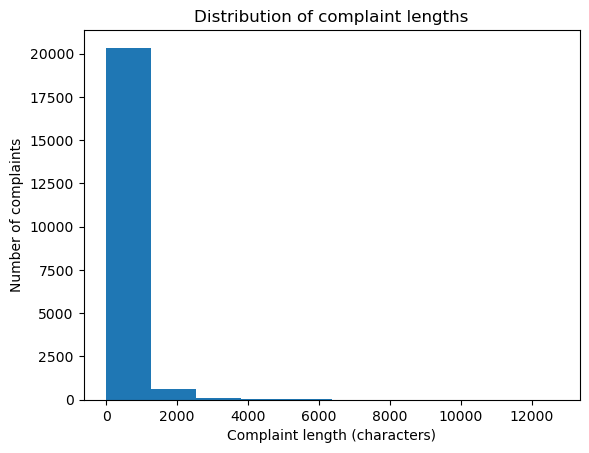

In [52]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_lengths = df_clean["complaint_POS_removed"].str.len()
# Plot the distribution of the complaint lengths
plt.hist(complaint_lengths)
plt.xlabel("Complaint length (characters)")
plt.ylabel("Number of complaints")
plt.title("Distribution of complaint lengths")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [56]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text


def create_wordcloud(text):
    # Create a WordCloud object
    word_cloud = wordcloud.WordCloud(
      max_words=40,
      background_color="white",
      width=500,
      height=250,
      random_state=100,
      collocation=False
    )

    # Generate the word cloud
    word_cloud.generate(text)

    return word_cloud

wordcloud = create_wordcloud(df_clean["complaint_POS_removed"].str.cat(sep=" "))

# Display the word cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: name 'wordcloud' is not defined

In [57]:
word_cloud = WordCloud(collocations = False, width = 1000, height = 500, max_words = 40, random_state = 100).generate(" ".join(df_clean["pos_filtered_complaints"]))
plt.figure(figsize = (20, 10))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

NameError: name 'WordCloud' is not defined

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).


In [ ]:
#Print the top 10 words in the unigram frequency


In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).


In [ ]:
#Print the top 10 words in the bigram frequency

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).


In [ ]:
#Print the top 10 words in the trigram frequency

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [ ]:
#All masked texts has been removed
df_clean

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



